In [260]:
import pandas as pd
import numpy as np
import math

In [261]:
transactions = pd.read_csv('transactions.csv')

In [262]:
transactions.head()

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,...,email,social,web,gender,age,income,F,M,O,member_since_month
0,0009655768c64bdeb2e877511632db8f,168.0,NaN,5a8bc65990b245e5a138643cd4eb9837,168.0,192.0,NaN,0.0,0.0,72.0,...,1.0,1.0,0.0,M,33.0,72000.0,0.0,1.0,0.0,45.0
1,0009655768c64bdeb2e877511632db8f,228.0,22.16,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,M,33.0,72000.0,0.0,1.0,0.0,45.0
2,0009655768c64bdeb2e877511632db8f,336.0,NaN,3f207df678b143eea3cee63160fa8bed,336.0,372.0,NaN,0.0,0.0,96.0,...,1.0,0.0,1.0,M,33.0,72000.0,0.0,1.0,0.0,45.0
3,0009655768c64bdeb2e877511632db8f,414.0,8.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,M,33.0,72000.0,0.0,1.0,0.0,45.0
4,0009655768c64bdeb2e877511632db8f,528.0,14.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,M,33.0,72000.0,0.0,1.0,0.0,45.0


lets keep the rows which contain either transactions or offers that have actually been viewed - only those can have an impact onto the customer

In [263]:
transactions = transactions[(transactions.offer_type=='transaction') | (transactions.time_viewed.isnull()==False)].copy()
#transactions['common_time'] = transactions.apply(lambda x: x['time_received'] if x['event']!='transaction' else x['time'],axis=1)
transactions.sort_values(['person','time','offer_id'],inplace=True)

define the helper columns to calculate a conversion rate

In [264]:
conv= transactions.copy()
conv.loc[: ,'converted'] = (conv.time_completed.isnull()==False)
conv.loc[:,'viewed'] = (conv.time_viewed.isnull()==False)

over all conversion rate

In [265]:
conv_general = conv[conv['offer_id'].isnull()==False]['converted'].sum() / conv[conv['offer_id'].isnull()==False]['viewed'].sum()
conv_general

0.5675592894022928

conversion rate separated by offer types

In [266]:
def conversion_by_offer_type(offer_type, df):
    return df[(df['offer_type']==offer_type)]['converted'].sum() / df[(df['offer_type']==offer_type)]['viewed'].sum()

for offer in ['bogo','discount','informational']:
    print(offer,'-conversion: ',conversion_by_offer_type(offer,conv))


bogo -conversion:  0.5387339978748166
discount -conversion:  0.7046728971962617
informational -conversion:  0.3854700854700855


In [267]:
conv[(conv.converted & conv.viewed)].head()

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,...,web,gender,age,income,F,M,O,member_since_month,converted,viewed
12,0011e0d4e6b944f998e987f904e8c1e5,168.0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,3.0,3.0,168.0,...,1.0,O,40.0,57000.0,0.0,0.0,1.0,54.0,True,True
15,0011e0d4e6b944f998e987f904e8c1e5,408.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,5.0,5.0,240.0,...,1.0,O,40.0,57000.0,0.0,0.0,1.0,54.0,True,True
16,0011e0d4e6b944f998e987f904e8c1e5,504.0,NaN,9b98b8c7a33c4b65b9aebfe6a799e6d9,504.0,516.0,576.0,5.0,5.0,168.0,...,1.0,O,40.0,57000.0,0.0,0.0,1.0,54.0,True,True
20,0020c2b971eb4e9188eac86d93036a77,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,54.0,2.0,2.0,240.0,...,1.0,F,59.0,90000.0,1.0,0.0,0.0,32.0,True,True
26,0020c2b971eb4e9188eac86d93036a77,408.0,NaN,4d5c57ea9a6940dd891ad53e9dbe8da0,408.0,426.0,510.0,10.0,10.0,120.0,...,1.0,F,59.0,90000.0,1.0,0.0,0.0,32.0,True,True


lets think about some features to be helpful
- average time deltas between received and viewed
- average time deltas between viewed and completed
- columns for converted per offer_type
- number of transactions
- average spenditure
- accumulation of viewed offers
- accumulation of completed offers
- accumulated reward


In [330]:
df = conv[:].copy()

In [331]:
df.head(10).columns

Index(['person', 'time', 'amount', 'offer_id', 'time_received', 'time_viewed',
       'time_completed', 'reward', 'potential_reward', 'duration',
       'offer_type', 'difficulty', 'mobile', 'email', 'social', 'web',
       'gender', 'age', 'income', 'F', 'M', 'O', 'member_since_month',
       'converted', 'viewed'],
      dtype='object')

In [333]:
# First, let's initialize all those features + some temporary ones to save data

# flag if the row has a transaction
df['is_transaction'] = 0 
df.loc[df['offer_type']=='transaction', 'is_transaction'] = 1
# flag if the row has an offer completed
df['is_completed'] = 0
df.loc[df['converted']==1, 'is_completed'] = 1

df['count_offers_completed'] = 0
df['count_offers_viewed'] = 0
df['count_transactions'] = 0
df['avg_spending'] = 0
df['avg_reward'] = 0
df['delta_time_reception_viewed'] = df['time_viewed'] - df['time_received']
df['delta_time_viewed_completion'] = df['time_completed'] - df['time_viewed']
df['delta_time_reception_viewed_avg'] = 0
df['delta_time_viewed_completion_avg'] = 0

# Customer of previous row - to check if she's the same of the actual
df['prev_person'] = df['person'].shift(1)
df.reset_index(drop=True,inplace=True)
for i, row in df.iterrows():
    if i % 10000 == 0: # print advancement
        print(i)
    if row['person'] == row['prev_person']: # modify data only if the previous customer is the same as current

        # Add 1 if previous offer was completed
        df.loc[i, 'count_offers_completed'] = df.loc[i-1, 'count_offers_completed'] + df.loc[i-1, 'is_completed']
        # increment one on each offer - we only have offers in dataset that are viewed since unviewed were eliminated before
        df.loc[i, 'count_offers_viewed'] = df.loc[i-1, 'count_offers_viewed'] + (1 if df.loc[i-1, 'offer_type'] != 'transaction' else 0)
        # Add 1 if previous row was a transaction
        df.loc[i, 'count_transactions'] = df.loc[i-1, 'count_transactions'] + df.loc[i-1, 'is_transaction']
        # Add previous time from reception to view
        df.loc[i, 'delta_time_reception_viewed_avg'] = np.nansum((df.loc[i-1, 'delta_time_reception_viewed_avg'], df.loc[i-1, 'delta_time_reception_viewed']))
        # Add previous time from view to completion
        df.loc[i, 'delta_time_viewed_completion_avg'] = np.nansum((df.loc[i-1, 'delta_time_viewed_completion_avg'], df.loc[i-1, 'delta_time_reception_viewed_avg']))

        # Add previous amount if previous row was a transaction
        df.loc[i, 'avg_spending'] = df.loc[i-1, 'avg_spending'] + (0 if df.loc[i-1, 'is_transaction'] == 0 else df.loc[i-1, 'amount'])
        # Add previous reward if previous row has a reward
        df.loc[i, 'avg_reward'] = np.nansum((df.loc[i-1, 'avg_reward'], df.loc[i-1, 'reward']))

# Calculate the averages from the sums
df['delta_time_reception_viewed_avg'] /= df['count_offers_viewed']
df['delta_time_viewed_completion_avg'] /= df['count_offers_completed']
df['avg_spending'] /= df['count_transactions']
df['avg_reward'] /= df['count_offers_completed']

# df['delta_time_reception_viewed_avg'].fillna(0, inplace=True)
# df['delta_time_viewed_completion_avg'].fillna(0, inplace=True)
# df['avg_spending'].fillna(0, inplace=True)

df['delta_time_reception_viewed_avg'].fillna(0, inplace=True)
df['delta_time_viewed_completion_avg'].fillna(0, inplace=True)
df['avg_spending'].fillna(0, inplace=True)
df['avg_reward'].fillna(0,inplace=True)

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000


In [334]:
for offer_type in ['bogo','discount','informational']:
    df.loc[(df['offer_type']==offer_type)&(df['time_completed'].isnull()==False),offer_type] = 1
    df.loc[(df['offer_type']==offer_type)&(df['time_completed'].isnull()==True),offer_type] = 0

In [335]:
df[df['offer_type']=='discount']

,person,time,amount,offer_id,time_received,time_viewed,time_completed,reward,potential_reward,duration,...,avg_spending,avg_reward,delta_time_reception_viewed,delta_time_viewed_completion,delta_time_reception_viewed_avg,delta_time_viewed_completion_avg,prev_person,bogo,discount,informational
11,0011e0d4e6b944f998e987f904e8c1e5,168.0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,186.0,252.0,3.0,3.0,168.0,...,13.490000,0.0,18.0,66.0,6.0,inf,0011e0d4e6b944f998e987f904e8c1e5,NaN,1.0,NaN
14,0011e0d4e6b944f998e987f904e8c1e5,408.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,408.0,432.0,576.0,5.0,5.0,240.0,...,12.710000,3.0,24.0,144.0,14.0,60.0,0011e0d4e6b944f998e987f904e8c1e5,NaN,1.0,NaN
19,0020c2b971eb4e9188eac86d93036a77,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0.0,12.0,54.0,2.0,2.0,240.0,...,0.000000,0.0,12.0,42.0,0.0,0.0,0011e0d4e6b944f998e987f904e8c1e5,NaN,1.0,NaN
31,0020ccbbb6d84e358d3414a3ff76cffd,168.0,NaN,2298d6c36e964ae4a3e7e9706d1fb8c2,168.0,168.0,222.0,3.0,3.0,168.0,...,16.270000,0.0,0.0,54.0,0.0,0.0,0020ccbbb6d84e358d3414a3ff76cffd,NaN,1.0,NaN
49,003d66b6608740288d6cc97a6903f4f0,168.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,168.0,300.0,384.0,2.0,2.0,240.0,...,1.255000,0.0,132.0,84.0,36.0,inf,003d66b6608740288d6cc97a6903f4f0,NaN,1.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166180,fff8957ea8b240a6b5e634b6ee8eafcf,408.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,408.0,432.0,NaN,NaN,2.0,240.0,...,2.030000,0.0,24.0,NaN,0.0,0.0,fff8957ea8b240a6b5e634b6ee8eafcf,NaN,0.0,NaN
166199,ffff82501cea40309d5fdd7edcca4a07,0.0,NaN,fafdcd668e3743c1bb461111dcafc2a4,0.0,6.0,60.0,2.0,2.0,240.0,...,0.000000,0.0,6.0,54.0,0.0,0.0,fffad4f4828548d1b5583907f2e9906b,NaN,1.0,NaN
166203,ffff82501cea40309d5fdd7edcca4a07,168.0,NaN,0b1e1539f2cc45b7b9fa7c272da2e1d7,168.0,174.0,198.0,5.0,5.0,240.0,...,10.786667,2.0,6.0,24.0,6.0,18.0,ffff82501cea40309d5fdd7edcca4a07,NaN,1.0,NaN
166209,ffff82501cea40309d5fdd7edcca4a07,336.0,NaN,2906b810c7d4411798c6938adc9daaa5,336.0,354.0,384.0,2.0,2.0,168.0,...,16.091250,3.5,18.0,30.0,6.0,42.0,ffff82501cea40309d5fdd7edcca4a07,NaN,1.0,NaN


lets try to get an overview on categorical and numerical features by creating some data frames of conversion

In [336]:
def sturges_binning(feature, df, correction=1):
#     feature = 'age'
    binning_series = df[feature]
    min_ = min(binning_series)
    max_ = max(binning_series)
    len_ = len(binning_series)
    sturges_bin_width = np.ceil((max_ - min_)/(np.ceil(math.log(len_, 2))+correction))
    return np.arange(min_,max_+sturges_bin_width,sturges_bin_width)

In [337]:
def feature_df(feature,df,numerical=True, correction=1):
    narrow = [feature]+['bogo','discount','informational']
    columns = ['bogo','discount','informational']
    if numerical:
        results = df[narrow].groupby(pd.cut(df[feature],bins=sturges_binning(feature,df,correction))).mean().drop(feature,axis=1)
    else:
        results =  df[narrow].groupby([feature]).mean()
    return results

In [338]:
df.columns

Index(['person', 'time', 'amount', 'offer_id', 'time_received', 'time_viewed',
       'time_completed', 'reward', 'potential_reward', 'duration',
       'offer_type', 'difficulty', 'mobile', 'email', 'social', 'web',
       'gender', 'age', 'income', 'F', 'M', 'O', 'member_since_month',
       'converted', 'viewed', 'is_transaction', 'is_completed',
       'count_offers_completed', 'count_offers_viewed', 'count_transactions',
       'avg_spending', 'avg_reward', 'delta_time_reception_viewed',
       'delta_time_viewed_completion', 'delta_time_reception_viewed_avg',
       'delta_time_viewed_completion_avg', 'prev_person', 'bogo', 'discount',
       'informational'],
      dtype='object')

In [1]:
### todo put it in data folder

In [341]:
df.to_csv('features.csv')

In [339]:
import seaborn as sns


In [340]:
display(feature_df('gender',df,False))
display(feature_df('income',df,numerical=True,correction=-5))
display(feature_df('member_since_month',df,numerical=True))
display(feature_df('avg_spending',df,numerical=True))
display(feature_df('count_transactions',df,numerical=True))

,bogo,discount,informational
gender,,,
F,0.650673,0.766456,0.375448
M,0.456973,0.660086,0.392891
O,0.676157,0.723247,0.385093


,bogo,discount,informational
income,,,
"(30000.0, 36924.0]",0.321323,0.610329,0.497860
"(36924.0, 43848.0]",0.337060,0.612730,0.461538
"(43848.0, 50772.0]",0.407305,0.636842,0.451488
"(50772.0, 57696.0]",0.511398,0.677787,0.400752
"(57696.0, 64620.0]",0.535358,0.683274,0.411463
"(64620.0, 71544.0]",0.546868,0.701523,0.377932
"(71544.0, 78468.0]",0.611321,0.753067,0.341365
"(78468.0, 85392.0]",0.720877,0.800487,0.331783
"(85392.0, 92316.0]",0.680454,0.755066,0.291734


,bogo,discount,informational
member_since_month,,,
"(0.0, 4.0]",0.408946,0.852941,0.544118
"(4.0, 8.0]",0.416413,0.847107,0.514085
"(8.0, 12.0]",0.386581,0.812030,0.493243
"(12.0, 16.0]",0.383513,0.815094,0.492857
"(16.0, 20.0]",0.410596,0.814050,0.541935
"(20.0, 24.0]",0.500000,0.793103,0.458333
"(24.0, 28.0]",0.753155,0.918033,0.498282
"(28.0, 32.0]",0.779743,0.917175,0.487654
"(32.0, 36.0]",0.771997,0.928999,0.493411


,bogo,discount,informational
avg_spending,,,
"(0.0, 51.0]",0.569374,0.744178,0.427647
"(51.0, 102.0]",0.852459,0.857143,0.627907
"(102.0, 153.0]",0.921053,0.692308,0.318182
"(153.0, 204.0]",0.722222,1.000000,0.111111
"(204.0, 255.0]",0.909091,0.857143,0.000000
"(255.0, 306.0]",1.000000,0.800000,0.666667
"(306.0, 357.0]",0.666667,1.000000,0.000000
"(357.0, 408.0]",NaN,1.000000,1.000000
"(408.0, 459.0]",0.000000,1.000000,0.000000


,bogo,discount,informational
count_transactions,,,
"(0.0, 2.0]",0.507306,0.661636,0.336873
"(2.0, 4.0]",0.562790,0.713980,0.393038
"(4.0, 6.0]",0.644301,0.804644,0.465662
"(6.0, 8.0]",0.663810,0.848176,0.524658
"(8.0, 10.0]",0.639548,0.881579,0.548729
"(10.0, 12.0]",0.565502,0.867684,0.557377
"(12.0, 14.0]",0.546429,0.814433,0.651163
"(14.0, 16.0]",0.364341,0.873874,0.615385
"(16.0, 18.0]",0.396825,0.833333,0.548387


we can see in the data frame overview on top that high spendings do not give us any benefit from regarding conversion rate since most of the time there is no data

we must determine which columns look interesting for a model to train. from the above mentioned features we take the following

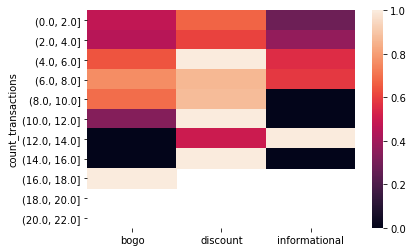

In [322]:
# display(sns.heatmap(feature_df('gender',df,False)))
# display(sns.heatmap(feature_df('income',df,numerical=True,correction=-5)))
# display(sns.heatmap(feature_df('member_since_month',df,numerical=True)))
# display(sns.heatmap(feature_df('avg_spending',df,numerical=True)))
display(sns.heatmap(feature_df('count_transactions',df,numerical=True)))

In [323]:
df.columns

Index(['person', 'time', 'amount', 'offer_id', 'time_received', 'time_viewed',
       'time_completed', 'reward', 'potential_reward', 'duration',
       'offer_type', 'difficulty', 'mobile', 'email', 'social', 'web',
       'gender', 'age', 'income', 'F', 'M', 'O', 'member_since_month',
       'converted', 'viewed', 'is_transaction', 'is_completed',
       'count_offers_completed', 'count_offers_viewed', 'count_transactions',
       'avg_spending', 'avg_reward', 'delta_time_reception_viewed',
       'delta_time_viewed_completion', 'delta_time_reception_viewed_avg',
       'delta_time_viewed_completion_avg', 'prev_person', 'bogo', 'discount',
       'informational'],
      dtype='object')

In [324]:
remove_features = ['person','time','amount', 'offer_id', 'time_received', 'time_viewed', 'mobile', 'email', 'social', 'web','converted','delta_time_reception_viewed','prev_person',
       'delta_time_viewed_completion','gender','O','time_completed', 'reward', 'potential_reward', 'duration','offer_type', 'difficulty','is_transaction', ]
kept_features = [ 'person',
       'age', 'income', 'F', 'M', 'member_since_month','viewed',  'is_completed',
       'count_offers_completed', 'count_offers_viewed', 'count_transactions','avg_spending', 'avg_reward',  'delta_time_reception_viewed_avg',
       'delta_time_viewed_completion_avg', 'bogo','discount', 'informational']

In [325]:
df[kept_features]

,person,age,income,F,M,member_since_month,viewed,is_completed,count_offers_completed,count_offers_viewed,count_transactions,avg_spending,avg_reward,delta_time_reception_viewed_avg,delta_time_viewed_completion_avg,bogo,discount,informational
0,0009655768c64bdeb2e877511632db8f,33.0,72000.0,0.0,1.0,45.0,True,0,0,0,0,0.000,0.0,0.0,0.0,NaN,NaN,0.0
1,0009655768c64bdeb2e877511632db8f,33.0,72000.0,0.0,1.0,45.0,False,0,0,1,0,0.000,0.0,24.0,0.0,NaN,NaN,NaN
2,0009655768c64bdeb2e877511632db8f,33.0,72000.0,0.0,1.0,45.0,True,0,0,1,1,22.160,0.0,24.0,inf,NaN,NaN,0.0
3,0009655768c64bdeb2e877511632db8f,33.0,72000.0,0.0,1.0,45.0,False,0,0,2,1,22.160,0.0,30.0,inf,NaN,NaN,NaN
4,0009655768c64bdeb2e877511632db8f,33.0,72000.0,0.0,1.0,45.0,False,0,0,2,2,15.365,0.0,30.0,inf,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,033d0a511a5c452ea2be37a23f8c6dcb,82.0,78000.0,0.0,1.0,28.0,False,0,1,1,1,14.790,2.0,42.0,42.0,NaN,NaN,NaN
1996,033d0a511a5c452ea2be37a23f8c6dcb,82.0,78000.0,0.0,1.0,28.0,True,0,1,1,2,17.930,2.0,42.0,84.0,NaN,NaN,0.0
1997,033d0a511a5c452ea2be37a23f8c6dcb,82.0,78000.0,0.0,1.0,28.0,False,0,1,2,2,17.930,2.0,36.0,126.0,NaN,NaN,NaN
1998,033f0ee2250e475b87f70115e7895957,62.0,108000.0,1.0,0.0,41.0,False,0,0,0,0,0.000,0.0,0.0,0.0,NaN,NaN,NaN


In [329]:
bogo = df[df.bogo == 1]
bogo_kept= bogo[kept_features]
bogo_kept.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 114 entries, 15 to 1970
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   person                            114 non-null    object 
 1   age                               114 non-null    float64
 2   income                            114 non-null    float64
 3   F                                 114 non-null    float64
 4   M                                 114 non-null    float64
 5   member_since_month                114 non-null    float64
 6   viewed                            114 non-null    bool   
 7   is_completed                      114 non-null    int64  
 8   count_offers_completed            114 non-null    int64  
 9   count_offers_viewed               114 non-null    int64  
 10  count_transactions                114 non-null    int64  
 11  avg_spending                      114 non-null    float64
 12  avg_re